# Combined Cycle Power Plant Data

## Overview

This report presents a comprehensive analysis conducted on a dataset from a Combined Cycle Power Plant over a six-year operation period (2006-2011), during which the plant was fully loaded. The study focused on utilizing hourly average ambient variables—Temperature (T), Ambient Pressure (AP), Relative Humidity (RH), and Exhaust Vacuum (V)—to predict the plant's net hourly electrical energy output (EP).

### Data Acquisition and Exploration

- **Data Source**: The dataset was obtained from the UCI Machine Learning Repository's [Combined Cycle Power Plant dataset](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant).
- A thorough initial examination revealed the dataset comprises several rows and columns, representing individual measurements and their corresponding ambient variables.
- Pairwise scatterplots were generated to visualize relationships between all variables, revealing interesting patterns and correlations.
- Descriptive statistics, including mean, median, range, quartiles, and interquartile ranges for each variable, were computed and summarized, providing insights into the data distribution and variability.

### Regression Analysis

- Simple linear regression models were applied to each predictor against the response, identifying statistically significant associations and highlighting potential outliers.
- A multiple regression model incorporating all predictors was then fitted, pinpointing predictors significantly associated with the electrical output.
- Coefficients from both simple and multiple regression models were compared, investigating non-linear associations and the impact of predictor interactions on the response.

### Model Refinement

- Efforts to improve the model included the introduction of interaction terms and exploration of nonlinear associations between predictors and the response. The refined models were trained on a randomly selected 70% subset of the data, incorporating all predictors along with their interactions and quadratic nonlinearities.
- Statistically insignificant variables were pruned based on their p-values, and the models were subsequently tested on the remaining data points. Training and test mean squared errors (MSEs) were reported for both models.

### KNN Regression

- The k-nearest neighbor regression technique was employed, utilizing both normalized and raw features to find the optimal k value that minimized prediction error. The investigation spanned k values from 1 to 100.
- Train and test errors were plotted as a function of 1/k, facilitating the selection of the best k value for the model.

### Comparative Analysis and Conclusions

- A comparison between the KNN Regression model and the linear regression model with the smallest test error was conducted. This comparison offered valuable insights into the strengths and limitations of each modeling approach.
- The analysis confirmed the presence of nonlinear associations between some predictors and the response, as well as statistically significant interactions between certain predictors.

This summary encapsulates the analytical processes undertaken and highlights key findings from the study of the Combined Cycle Power Plant dataset, underscoring the practical applications of statistical and machine learning techniques in predicting energy output based on environmental conditions.


In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.spatial.distance import euclidean

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# Exploring the Data

Notes and issues with this dataset. 
1. The column 'PE' should be 'EP', but I'll leave it alone
2. AT likely stands for Ambient Temperature, so I'll leave the name alone. 
3. Fortunately there are no missing values

After reading through the reference paper, I will not change anything about the data.
Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, http://dx.doi.org/10.1016/j.ijepes.2014.02.027.

### Load excel file

In [37]:
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

### Inspect dataframe

In [38]:
ccpp_df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [39]:
# Check for missing values
missing_values = ccpp_df.isna()
missing_count = missing_values.sum().sum()
print(f'There are {missing_count} missing values in the dataframe')

There are 0 missing values in the dataframe


# Inspection: How many rows are in this data set? How many columns? What do the rows and columns represent?

In [40]:
print(f'The Number of Rows in this dataset: {ccpp_df.shape[0]}')
print(f'The Number of Columns in this dataset: {ccpp_df.shape[1]}')
print('\n')
print('According to the reference paper, the rows correspond to the average hourly data received from the measurement points by the sensors at the powerplant')
print('\n')
print('The columns correspond to the ambient variables')


The Number of Rows in this dataset: 9568
The Number of Columns in this dataset: 5


According to the reference paper, the rows correspond to the average hourly data received from the measurement points by the sensors at the powerplant


The columns correspond to the ambient variables


### Making pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable.

Findings
1. As ambient temperature increases, energy output decreases
2. As Exhaust Steam Pressure (V) increases, energy output decreases
3. As Atmospheric Pressure (AP) increases, energy output looks like it may increase
4. As Relative Humidity (RH) increases, energy output looks like it may increase. Unsure.

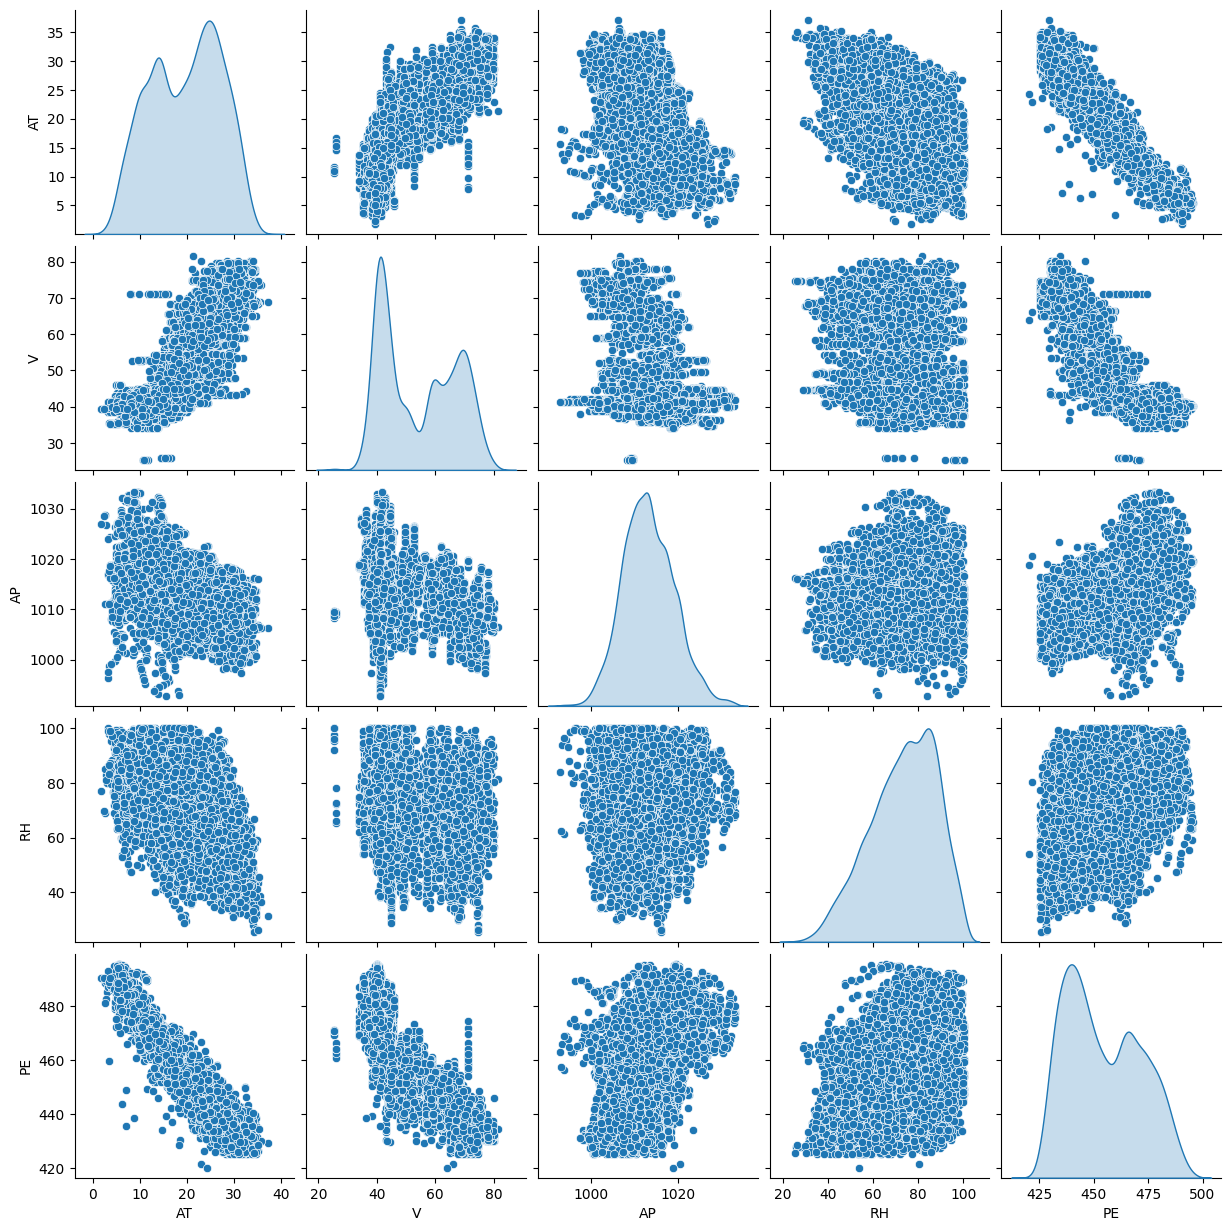

In [41]:
sns.pairplot(ccpp_df, vars=['AT', 'V', 'AP', 'RH', 'PE'], diag_kind='kde')
plt.show()

# Inspection: What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? 
Summarized in a table below

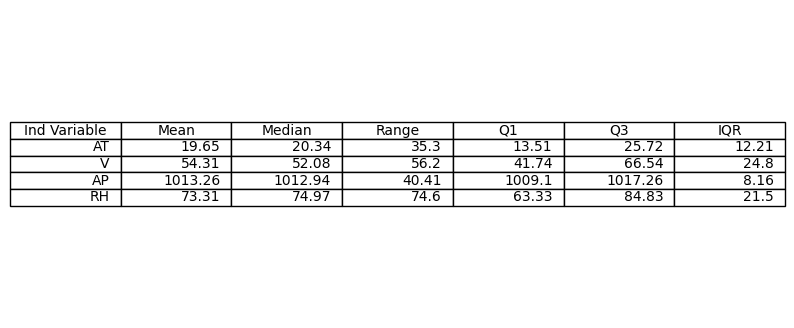

In [42]:
#Drop the dependent variable
ind_variable_columns = ccpp_df.columns.drop('PE')

# Create an empty list to store summary DataFrames for each variable
dfs = []

# Calculate stats for each of the independent variables
for ind_variable in ind_variable_columns:
    variable = ccpp_df[ind_variable]
    mean = round(variable.mean(), 2)
    median = round(variable.median(), 2)
    data_range = round(variable.max() - variable.min(),2)
    quantile_1 = round(variable.quantile(0.25), 2)
    quantile_3 = round(variable.quantile(0.75), 2)
    iqr = round(quantile_3 - quantile_1, 2)

    # Stats Dataframe created for the current independent variable
    stats_df = pd.DataFrame({'Ind Variable': [ind_variable],
                             'Mean': [mean],
                             'Median': [median],
                             'Range': [data_range],
                             'Q1': [quantile_1],
                             'Q3': [quantile_3],
                             'IQR': [iqr]})

    # Append the stats df to the list of dfs
    dfs.append(stats_df)

# Concatenate each of the stats df's made for each of the independent variabls
full_stats_df = pd.concat(dfs, ignore_index=True)

# Plot data in tabular format
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
ax.table(cellText=full_stats_df.values, colLabels=full_stats_df.columns, loc='center')
plt.show()

# For each predictor, a simple linear regression model will be fit to the data to predict the response.

As you will see below, the scatter plots of all of the independent variables against the dependent variable all indicate significant trends. As 'AT' and 'V' trend downward, 'PE' decreases. As 'AP' and 'RH' trend upward, 'PE' increases. There does appear to be a strong linear realtionship. This is obvious once you plot the linear regression line on each of the plots. This linear relationship is supported by p-values in the summary statistics tables which are incredibly small for each of the predictors.

### Plots with calculated linear regression lines

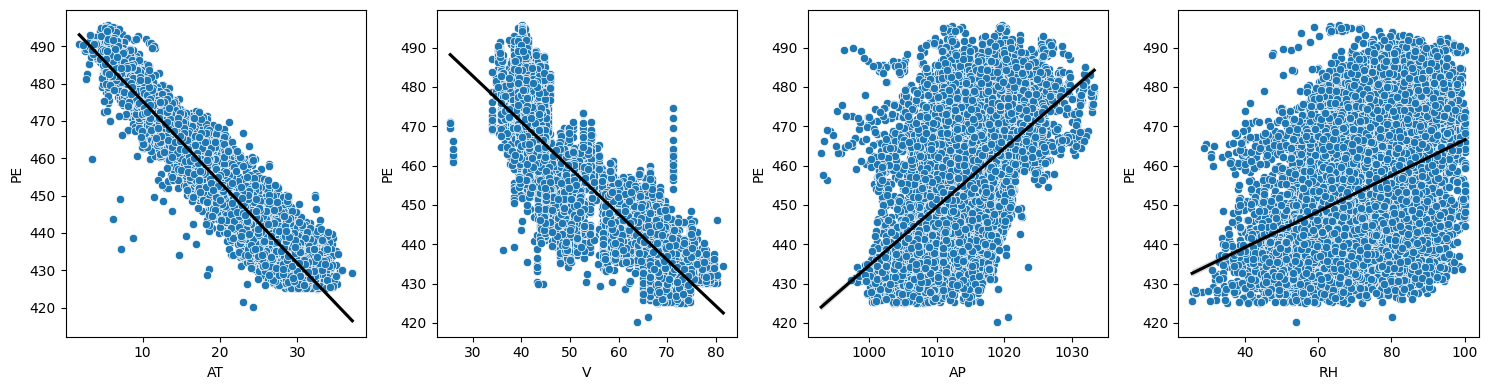

In [43]:
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')

# Create subplots in a single row
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Loop through each predictor variable
for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]  
    y = ccpp_df['PE']

    # Fit the linear regression model to the current predictor
    X = sm.add_constant(X)
    linear_model = sm.OLS(y, X).fit()

    # Plot the data and the linear regression model fit for the current predictor
    sns.scatterplot(data=ccpp_df, x=predictor, y='PE', ax=axes[i])
    sns.regplot(data=ccpp_df, x=predictor, y='PE', scatter=False, line_kws={"color": "black"}, ax=axes[i], marker='o')
    
    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel('PE')

plt.tight_layout()
plt.show()

### Summary statistics

In [44]:
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')
r2_list = []
p_list = []
linear_model_coefficients = []

# Loop through each predictor variable
for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]  
    y = ccpp_df['PE']

    # Fit the linear regression model to the current predictor
    X = sm.add_constant(X)
    linear_model = sm.OLS(y, X).fit()
    linear_model_coefficients.append(linear_model.params[1])

    #Examine statistics
    print(linear_model.summary())
    print("-" * 140)

    # Saving stats
    r2_list.append(linear_model.rsquared)
    p_list.append(linear_model.pvalues)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:48:44   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.0

/var/folders/4m/bqvgmfb96m36d900j15sckg40000gn/T/ipykernel_24376/2455035654.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  linear_model_coefficients.append(linear_model.params[1])
/var/folders/4m/bqvgmfb96m36d900j15sckg40000gn/T/ipykernel_24376/2455035654.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  linear_model_coefficients.append(linear_model.params[1])
/var/folders/4m/bqvgmfb96m36d900j15sckg40000gn/T/ipykernel_24376/2455035654.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame

# Removing Outliers and rerunning model to see if anything improves

After removing the outliers, the R2 values and the p-values barely changed, therefore I will not remove any outliers. Also, when I ran the models below on the dataset with the outliers removed things didn't change that much.

In [45]:
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

lower_bound = ccpp_df.quantile(0.25) - 1.5 * (ccpp_df.quantile(0.75) - ccpp_df.quantile(0.25))
upper_bound = ccpp_df.quantile(0.75) + 1.5 * (ccpp_df.quantile(0.75) - ccpp_df.quantile(0.25))

all_outlier_indices = []

# Find extreme outliers in each column
for col in ccpp_df.columns:
    outlier_indices = ccpp_df[(ccpp_df[col] < lower_bound[col]) | (ccpp_df[col] > upper_bound[col])].index
    all_outlier_indices.extend(outlier_indices)

# Dropping outliers calculated about
ccpp_df = ccpp_df.drop(list(set(all_outlier_indices)))

# Resetting the df to have correct indices
ccpp_df = ccpp_df.reset_index(drop=True)

In [46]:
r2_outliers_removed = []
p_outliers_removed = []

for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]  
    y = ccpp_df['PE']

    # Fit the linear regression model to the current predictor
    X = sm.add_constant(X)
    linear_model = sm.OLS(y, X).fit()

    # Saving stats
    r2_outliers_removed.append(linear_model.rsquared)
    p_outliers_removed.append(linear_model.pvalues)

In [47]:
print(f'AT vs PE: R2 Before and After outliers removed = {round(r2_list[0], 3)}, {round(r2_outliers_removed[0], 3)}')
print(f'V vs PE:  R2 Before and After outliers removed = {round(r2_list[1], 3)}, {round(r2_outliers_removed[1], 3)}')
print(f'AP vs PE: R2 Before and After outliers removed = {round(r2_list[2], 3)}, {round(r2_outliers_removed[2], 3)}')
print(f'RH vs PE: R2 Before and After outliers removed = {round(r2_list[3], 3)}, {round(r2_outliers_removed[3], 3)}')

AT vs PE: R2 Before and After outliers removed = 0.899, 0.898
V vs PE:  R2 Before and After outliers removed = 0.757, 0.755
AP vs PE: R2 Before and After outliers removed = 0.269, 0.272
RH vs PE: R2 Before and After outliers removed = 0.152, 0.151


In [48]:
# Resetting dataframe with outliers included
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Fiting a multiple regression model to predict the response using all of the predictors.

Running the multiple regression below you can see that the R^2 value is higher with all of the predictors in the model that the R^2 value of any single predictor alone. We can reject the null hypothesis for all of the predictos since they all have extremely low p-values.

In [49]:
# Define data
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')
X = ccpp_df[predictor_columns]
X = sm.add_constant(X)
y = ccpp_df['PE']

# Fit the multiple regression model with all predictors
multiple_model = sm.OLS(y, X).fit()
multiple_model_coefficients = multiple_model.params
multiple_model_coefficients = multiple_model_coefficients[1:]

print(multiple_model.summary())
print('\n')
print(f'The R^2 valued for the multiple regression: = {multiple_model.rsquared}')

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:48:56   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

# Comparing the Univariate Regression models with the Multiple Regression Model

The coefficients for the Univariate Regression models and the Multiple Regression Model are different for all of the predictors except 'AT', which is still pretty close. Some of the coefficients, 'AP' changed signs, while the other just slightly changed in magnitude. The coefficient with the largest change was 'RH'.

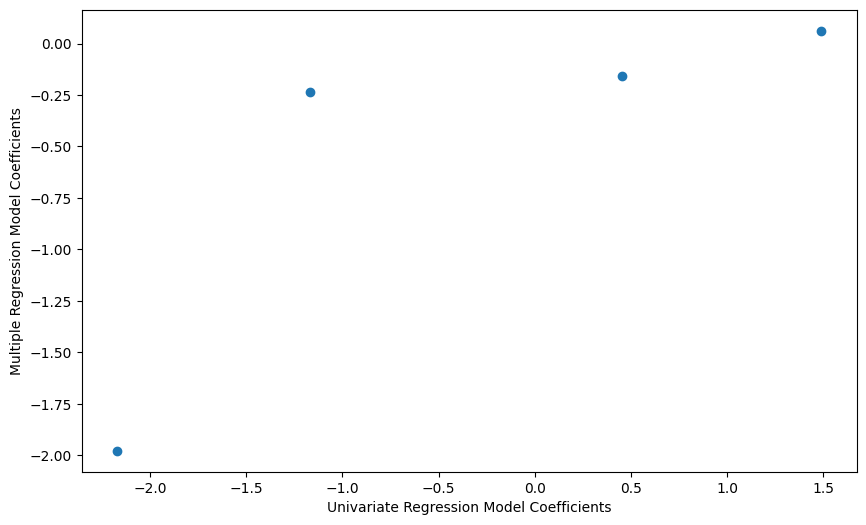

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(linear_model_coefficients, multiple_model_coefficients)
plt.xlabel('Univariate Regression Model Coefficients')
plt.ylabel('Multiple Regression Model Coefficients')
plt.show()

# Checking to see if there is any evidence of nonlinear association between any of the predictors and the response

Yes, based on the residuals graphs below there appears to be nonlinearity. The trend lines appear to not be perfectly horizontal.

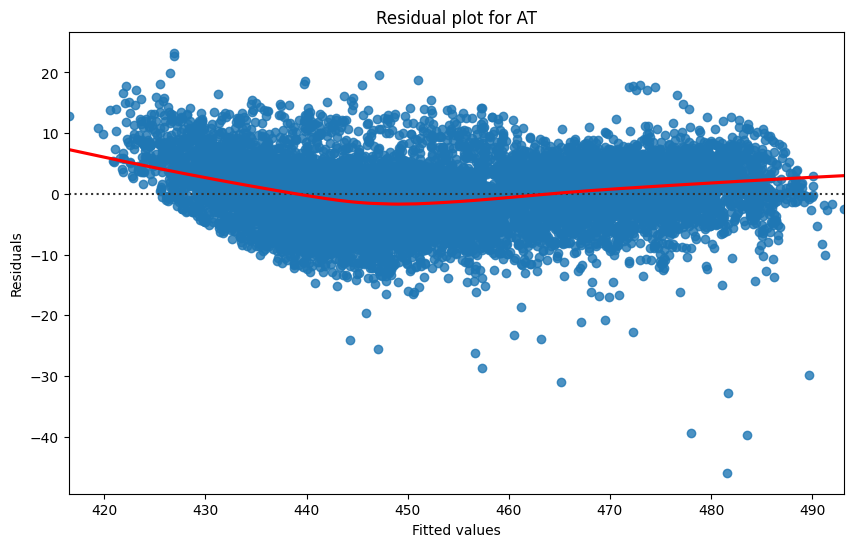

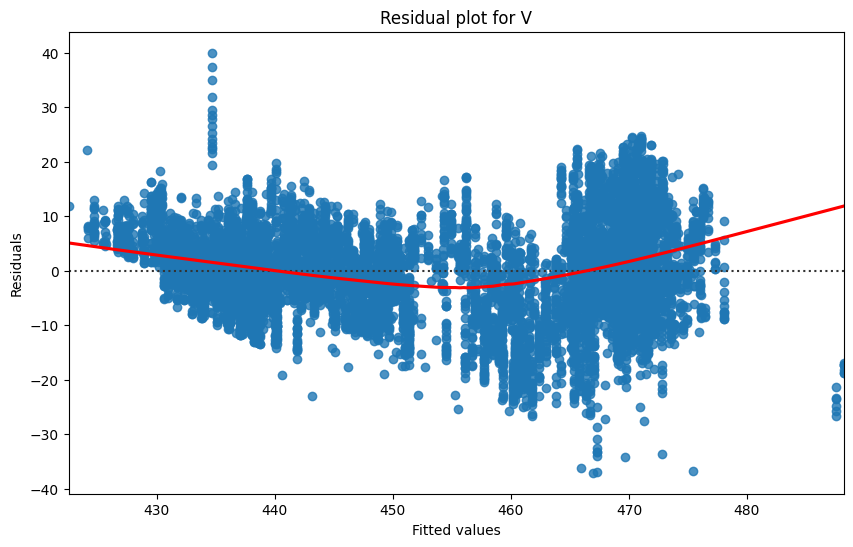

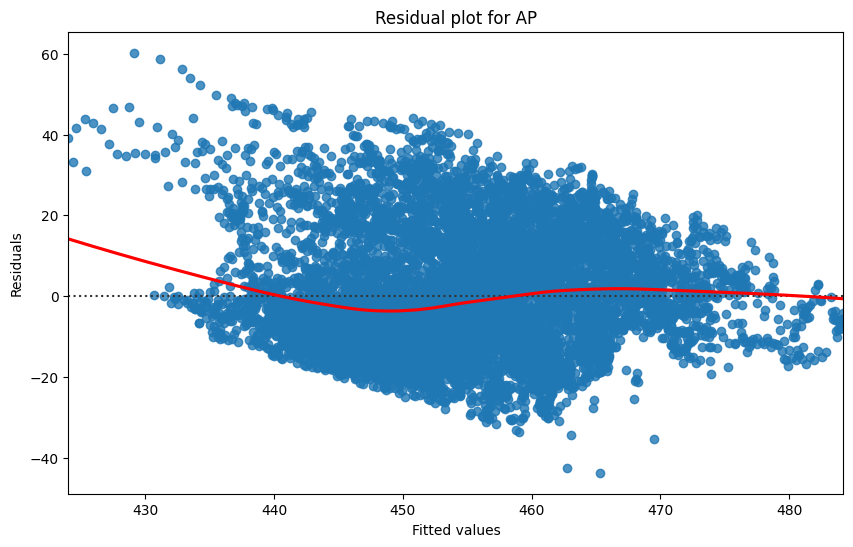

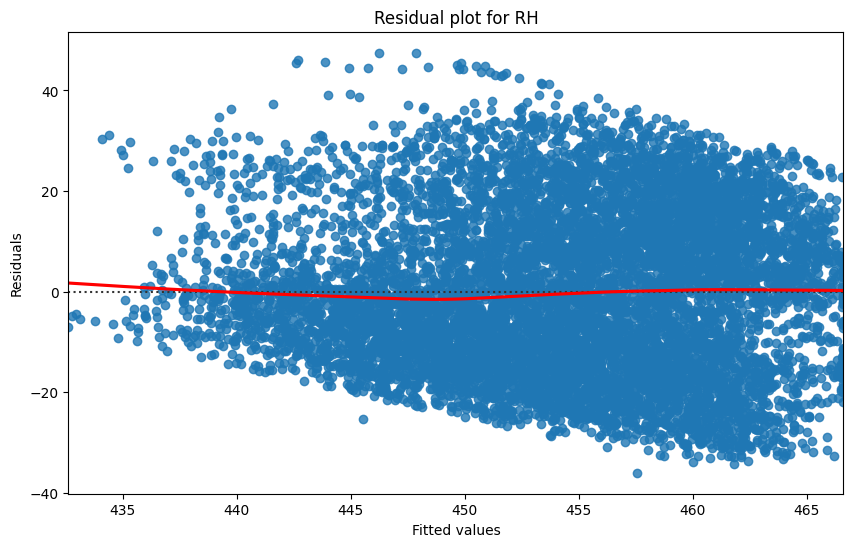

In [51]:
# Loop through each predictor variable
for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]
    y = ccpp_df['PE']

    # Fit the linear regression model to the current predictor
    X = sm.add_constant(X)
    linear_model = sm.OLS(y, X).fit()
    y_pred = linear_model.predict(X)
    
    # Calculating residuals to plot
    residuals = y - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Residual plot for {predictor}')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.show()

# Adding polynomial features.

The p-values for most of the independent variables with the added polynomial terms are statistically significant for most. This suggests that the relationship between these predictors and 'PE' is nonlinear. The only exception is for predictor 'V' where the p-value significance is lost with the second degree polynomial term added. Strangely enough thought there is significance again with the third degree polynomial term. Perhaps this is overfitting the data, but unlikely with such a low degree term.

Also, the trend lines on the residuals graphs appear to be more horizontal than before suggesting that the nonlinear models are better capturing the true relationships between the predictors and 'PE'

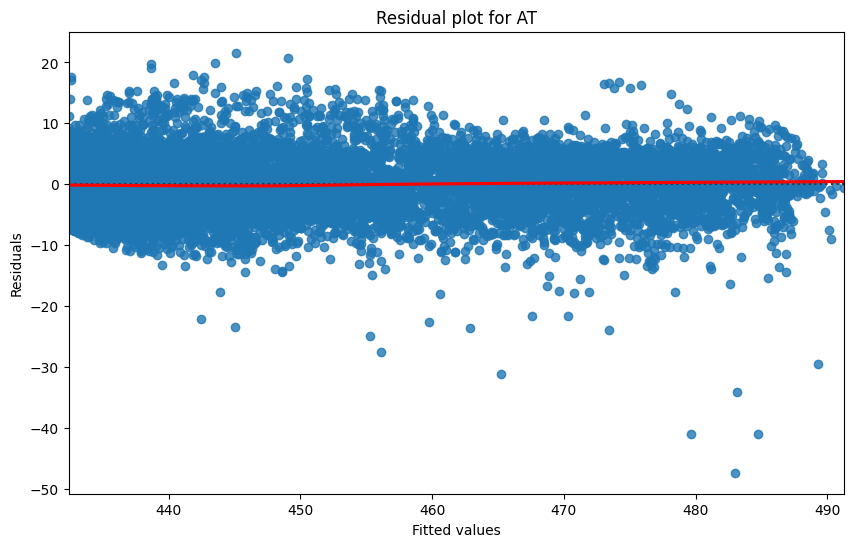

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:49:41   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

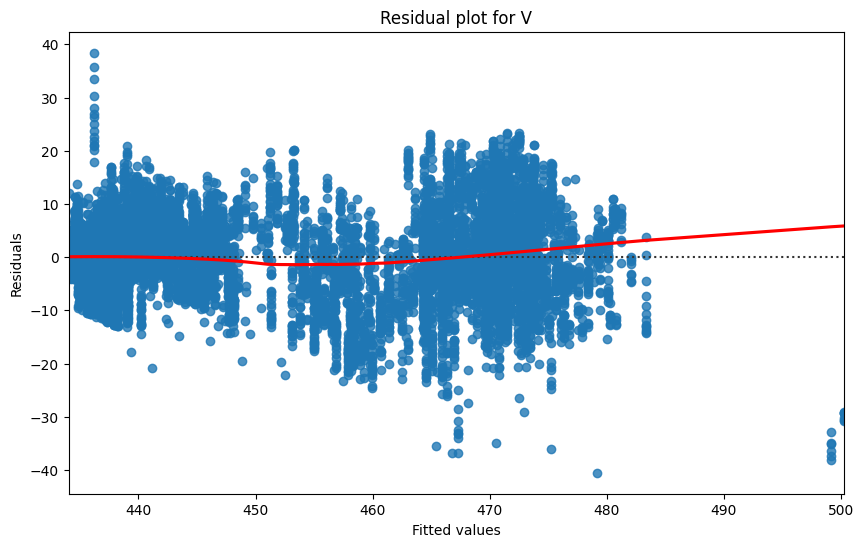

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:49:41   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

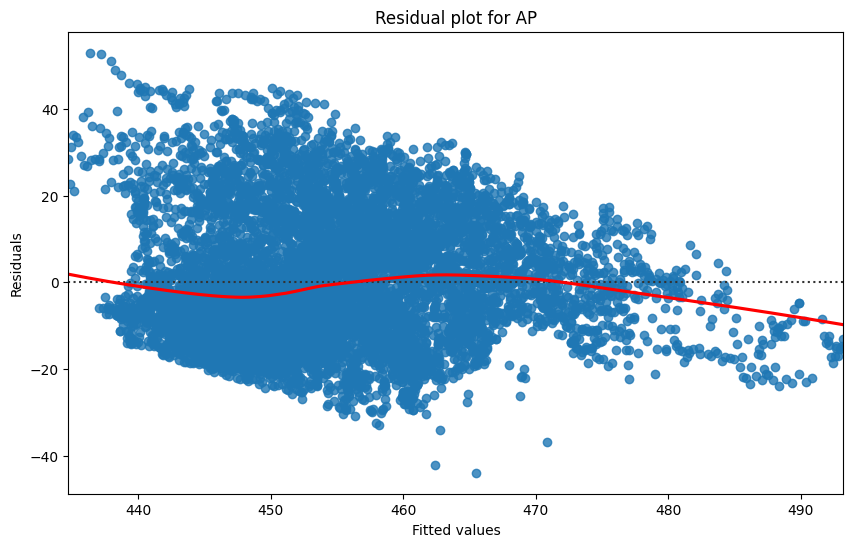

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:49:42   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

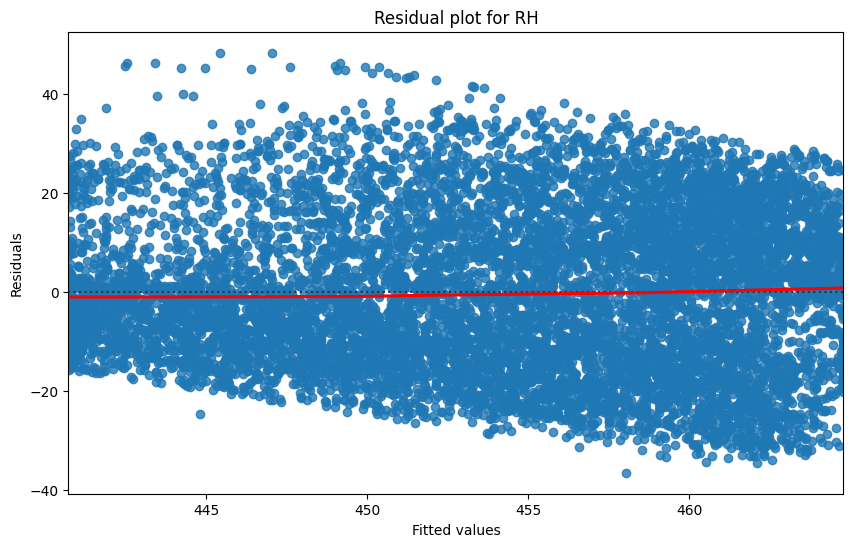

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:49:43   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

In [54]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')

# Loop through each predictor variable
for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]
    y = ccpp_df['PE']
    
    poly = PolynomialFeatures(3)
    X_poly = poly.fit_transform(ccpp_df[[predictor]])

    # Fit the linear regression model to the current predictor
    X = sm.add_constant(X_poly)
    linear_model = sm.OLS(y, X_poly).fit()
    y_pred = linear_model.predict(X_poly)

    # Calculating residuals to plot
    residuals = y - y_pred
    
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
    plt.title(f'Residual plot for {predictor}')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.show()
    print(linear_model.summary())


# Checking to see if there is any evidence of association of interactions of predictors with the response 

The full linear model below with the added interaction terms have produced several statistically significant results. The interaction terms: 'AT*V', 'AT*RH', 'V*AP', 'AP*RH'

In [55]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')

# For loop to generate interaction terms and then add them directly to the ccpp_df
for i, initial_column in enumerate(predictor_columns):
    for j, next_column in enumerate(predictor_columns):
        if i < j: # I needed to add this to prevent duplicates of interaction terms (Ex: AP*V and V*AP are the same thing)
            ccpp_df[f"{initial_column}*{next_column}"] = ccpp_df[initial_column] * ccpp_df[next_column]

# Fit the full linear regression model now with the interaction terms added
X = ccpp_df.drop(columns='PE')
X_with_const = sm.add_constant(X)
y = ccpp_df['PE']
linear_model = sm.OLS(y, X_with_const).fit()

print(linear_model.summary())


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:50:03   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

# Attempting to improve the model using possible interaction terms or nonlinear associations between the predictors and response

## Regression model on original data

In [56]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')

# Split the data into train and test sets (70/30)
X = ccpp_df[predictor_columns]
y = ccpp_df['PE']
train_df, test_df = train_test_split(ccpp_df, test_size=0.3, random_state=42)

# Create X_train, y_train, X_Test, Y_test
X_train = train_df[predictor_columns]
X_train_with_const = sm.add_constant(X_train)
y_train = train_df['PE']

X_test = test_df[predictor_columns]
X_test_with_const = sm.add_constant(X_test)
y_test = test_df['PE']

# Train model on the Training set
linear_model = sm.OLS(y_train, X_train_with_const).fit()

# Predict on training data and testing data
y_train_pred = linear_model.predict(X_train_with_const)
residuals_train = y_train - y_train_pred
mse_train = np.mean(residuals_train**2)

y_test_pred = linear_model.predict(X_test_with_const)
residuals_test = y_test - y_test_pred
mse_test = np.mean(residuals_test**2)

# Show results
print(f"Training MSE: {mse_train:.1f}")
print(f"Test MSE: {mse_test:.1f}")

print(linear_model.summary())

Training MSE: 20.6
Test MSE: 21.2
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.194e+04
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:50:06   Log-Likelihood:                -19630.
No. Observations:                6697   AIC:                         3.927e+04
Df Residuals:                    6692   BIC:                         3.930e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        467.8

## Regression model involving all possible interaction terms and quadratic nonlinearities

### Create a df with poly terms

In [57]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
predictor_columns = ccpp_df.columns.drop('PE')

# Create a new df to hold the results of the polynomial generation
poly_df = pd.DataFrame()

# Loop through each predictor variable
for i, predictor in enumerate(predictor_columns):
    X = ccpp_df[predictor]
    y = ccpp_df['PE']
    
    poly = PolynomialFeatures(3, include_bias=False)
    X_poly = poly.fit_transform(ccpp_df[[predictor]])

    poly_feature_df = pd.DataFrame(X_poly, columns=[f"{predictor}^{i}" for i in range(1, 4)])
    poly_df = pd.concat([poly_df, poly_feature_df], axis=1)

poly_df.drop(columns=['AT^1','V^1','AP^1','RH^1'], inplace=True)


### Create a df with interaction terms

In [58]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE'
original_predictor_columns = ccpp_df.columns.drop('PE')
predictor_columns = ccpp_df.columns.drop('PE')

# For loop to generate interaction terms and then add them directly to the ccpp_df
for i, initial_column in enumerate(original_predictor_columns):
    for j, next_column in enumerate(original_predictor_columns):
        if i < j: # I needed to add this to prevent duplicates of interaction terms (Ex: AP*V and V*AP are the same thing)
            interaction_column_name = f"{initial_column}*{next_column}"
            ccpp_df[f"{initial_column}*{next_column}"] = ccpp_df[initial_column] * ccpp_df[next_column]
            predictor_columns = predictor_columns.append(pd.Index([interaction_column_name])) 

ccpp_df_interaction = ccpp_df.copy()

### Combine the two df's and run the linear regression

In [59]:
result_interaction_poly = pd.concat([poly_df, ccpp_df_interaction], axis=1)
result_interaction_poly

,AT^2,AT^3,V^2,V^3,AP^2,AP^3,RH^2,RH^3,AT,V,AP,RH,PE,AT*V,AT*AP,AT*RH,V*AP,V*RH,AP*RH
0,223.8016,3348.071936,1743.8976,72825.163776,1.048719e+06,1.073962e+09,5353.8489,391741.124013,14.96,41.76,1024.07,73.17,463.26,624.7296,15320.0872,1094.6232,42765.1632,3055.5792,74931.2019
1,634.0324,15964.935832,3963.9616,249571.022336,1.040482e+06,1.061333e+09,3490.4464,206215.573312,25.18,62.96,1020.04,59.08,444.37,1585.3328,25684.6072,1487.6344,64221.7184,3719.6768,60263.9632
2,26.1121,133.432831,1552.3600,61162.984000,1.024468e+06,1.036925e+09,8489.7796,782248.292344,5.11,39.40,1012.16,92.14,488.56,201.3340,5172.1376,470.8354,39879.1040,3630.3160,93260.4224
3,435.1396,9077.012056,3285.5824,188329.583168,1.020585e+06,1.031036e+09,5873.6896,450159.570944,20.86,57.32,1010.24,76.64,446.48,1195.6952,21073.6064,1598.7104,57906.9568,4393.0048,77424.7936
4,117.0724,1266.723368,1406.2500,52734.375000,1.018545e+06,1.027946e+09,9335.4244,901988.705528,10.82,37.50,1009.23,96.62,473.90,405.7500,10919.8686,1045.4284,37846.1250,3623.2500,97511.8026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,277.2225,4615.754625,2469.0961,122689.385209,1.028216e+06,1.042622e+09,8281.0000,753571.000000,16.65,49.69,1014.01,91.00,460.03,827.3385,16883.2665,1515.1500,50386.1569,4521.7900,92274.9100
9564,173.9761,2294.744759,1535.0724,60144.136632,1.047900e+06,1.072704e+09,4459.5684,297809.977752,13.19,39.18,1023.67,66.78,469.62,516.7842,13502.2073,880.8282,40107.3906,2616.4404,68360.6826
9565,980.9424,30723.115968,5524.9489,410669.451737,1.026007e+06,1.039263e+09,1330.7904,48547.233792,31.32,74.33,1012.92,36.48,429.57,2328.0156,31724.6544,1142.5536,75290.3436,2711.5584,36951.3216
9566,599.2704,14670.139392,4823.3025,334978.358625,1.027912e+06,1.042159e+09,3892.5121,242853.829919,24.48,69.45,1013.86,62.39,435.74,1700.1360,24819.2928,1527.3072,70412.5770,4332.9855,63254.7254


In [60]:
predictor_columns = result_interaction_poly.columns.drop('PE')

# Split the data into train and test sets (70/30)
X = result_interaction_poly.drop(columns='PE')
y = result_interaction_poly['PE']
train_df, test_df = train_test_split(result_interaction_poly, test_size=0.3, random_state=100)

# Create X_train, y_train, X_Test, Y_test
X_train = train_df[predictor_columns]
X_train_with_const = sm.add_constant(X_train)
y_train = train_df['PE']

X_test = test_df[predictor_columns]
X_test_with_const = sm.add_constant(X_test)
y_test = test_df['PE']

# Train model on the Training set
linear_model = sm.OLS(y_train, X_train_with_const).fit()

# Predict on training data and testing data
y_train_pred = linear_model.predict(X_train_with_const)
residuals_train = y_train - y_train_pred
mse_train = np.mean(residuals_train**2)

y_test_pred = linear_model.predict(X_test_with_const)
residuals_test = y_test - y_test_pred
mse_test = np.mean(residuals_test**2)

# Show results
print(f"Training MSE: {mse_train:.5f}")
print(f"Test MSE: {mse_test:.5f}")

print(linear_model.summary())

Training MSE: 17.14161
Test MSE: 19.20183
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     6254.
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:50:15   Log-Likelihood:                -19017.
No. Observations:                6697   AIC:                         3.807e+04
Df Residuals:                    6679   BIC:                         3.819e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

### Using Backwards selection on the dataframe

In [61]:
result_interaction_poly = pd.concat([poly_df, ccpp_df_interaction], axis=1)

# Removing the terms that aren't statistically significant using backwards selection

#result_interaction_poly.drop(columns=['V*RH'],inplace=True)
#result_interaction_poly.drop(columns=['RH^3','V*RH' ],inplace=True)
result_interaction_poly.drop(columns=['RH^3','V*RH', 'V*AP'],inplace=True)

In [62]:
predictor_columns = result_interaction_poly.columns.drop('PE')

# Split the data into train and test sets (70/30)
X = result_interaction_poly.drop(columns='PE')
y = result_interaction_poly['PE']
train_df, test_df = train_test_split(result_interaction_poly, test_size=0.3, random_state=100)

# Create X_train, y_train, X_Test, Y_test
X_train = train_df[predictor_columns]
X_train_with_const = sm.add_constant(X_train)
y_train = train_df['PE']

X_test = test_df[predictor_columns]
X_test_with_const = sm.add_constant(X_test)
y_test = test_df['PE']

# Train model on the Training set
linear_model = sm.OLS(y_train, X_train_with_const).fit()

# Predict on training data and testing data
y_train_pred = linear_model.predict(X_train_with_const)
residuals_train = y_train - y_train_pred
mse_train = np.mean(residuals_train**2)

y_test_pred = linear_model.predict(X_test_with_const)
residuals_test = y_test - y_test_pred
mse_test = np.mean(residuals_test**2)

# Show results
print(f"Training MSE: {mse_train:.5f}")
print(f"Test MSE: {mse_test:.5f}")

print(linear_model.summary())

Training MSE: 17.14734
Test MSE: 19.21550
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     7595.
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:50:24   Log-Likelihood:                -19019.
No. Observations:                6697   AIC:                         3.807e+04
Df Residuals:                    6682   BIC:                         3.817e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const     

# KNN Regression

Best k value for the raw data: 5


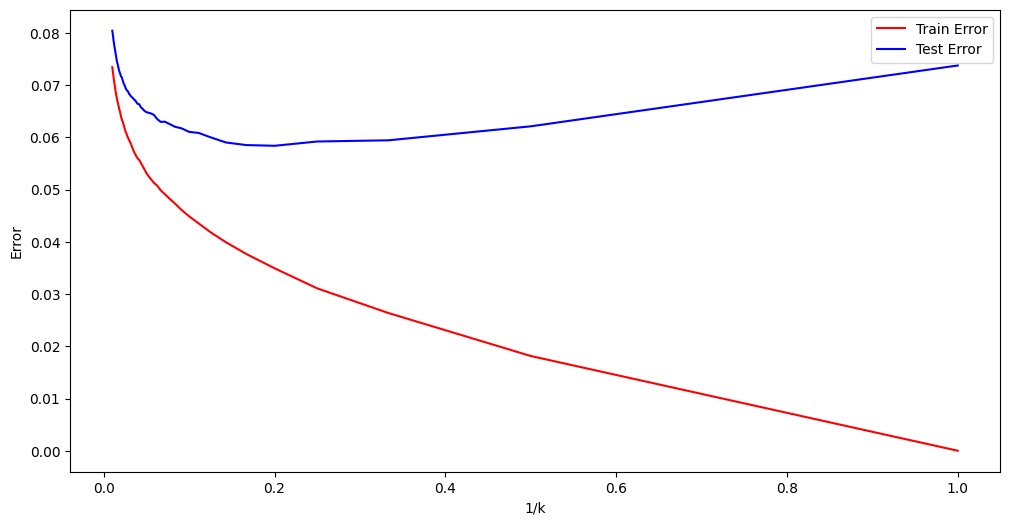

In [63]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE' and split the data
X = ccpp_df.drop(columns='PE')
y = ccpp_df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

train_errors = []
test_errors = []

k_values = range(1, 101)
inversek_values = [1/k for k in k_values]

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_errors.append(1 - knn.score(X_train, y_train))
    test_errors.append(1 - knn.score(X_test, y_test))

# Print the k value with the lowest test error
raw_index_of_min_test_error = np.argmin(test_errors)
raw_best_k = k_values[raw_index_of_min_test_error]
print(f"Best k value for the raw data: {raw_best_k}")

plt.figure(figsize=(12,6))
plt.plot(inversek_values, train_errors, label='Train Error', color='red')
plt.plot(inversek_values, test_errors, label='Test Error', color='blue')
plt.xlabel('1/k')
plt.ylabel('Error')
plt.legend()
plt.show()

Best k value for the normalized data: 3


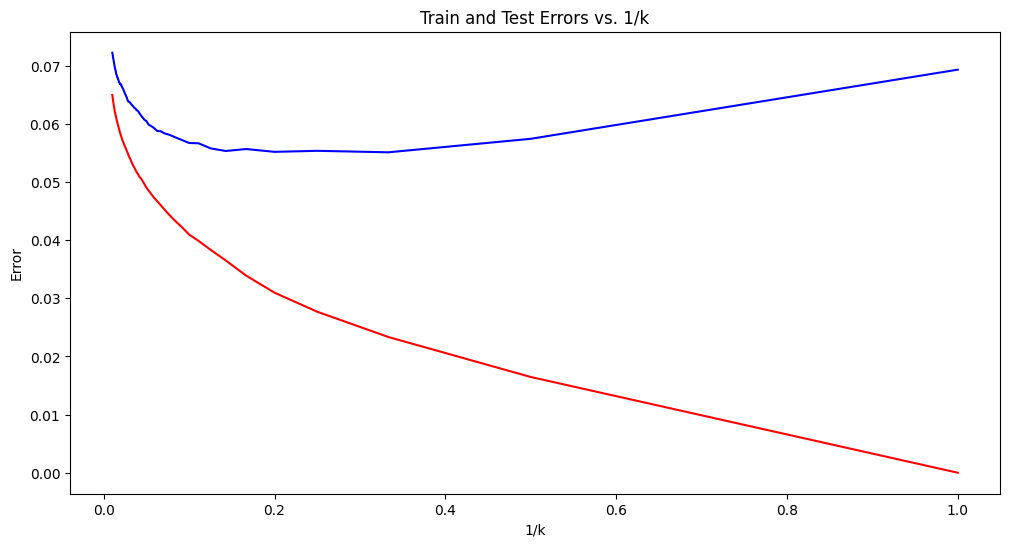

In [64]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop the dependent variable 'PE' and split the data
X = ccpp_df.drop(columns='PE')
y = ccpp_df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Normalizing the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

train_errors_norm = []
test_errors_norm = []

k_values = range(1, 101)
inversek_values = [1/k for k in k_values]

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    train_errors_norm.append(1 - knn.score(X_train_norm, y_train))
    test_errors_norm.append(1 - knn.score(X_test_norm, y_test))

# Print the k value with the lowest test error
norm_index_of_min_test_error = np.argmin(test_errors_norm)
norm_best_k = k_values[norm_index_of_min_test_error]
print(f"Best k value for the normalized data: {norm_best_k}")
    
plt.figure(figsize=(12,6))
plt.plot(inversek_values, train_errors_norm, label='Train Error', color='red')
plt.plot(inversek_values, test_errors_norm, label='Test Error', color='blue')
plt.xlabel('1/k')
plt.ylabel('Error')
plt.title('Train and Test Errors vs. 1/k')
plt.show()

### Run the model again to see what the MSE is

MSE at k=3:


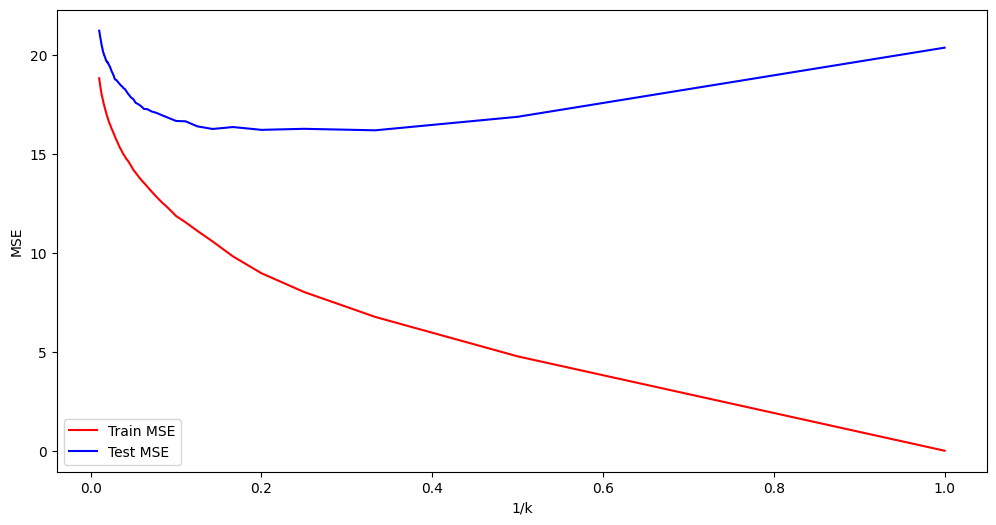

MSE at k=3: 16.21


In [65]:
# Define data again
ccpp_df = pd.read_excel('../data/ccpp_data/Folds5x2_pp.xlsx')

# Drop 'PE' and split the data
X = ccpp_df.drop(columns='PE')
y = ccpp_df['PE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Normalizing the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

train_mse_values = []
test_mse_values = []

k_values = range(1, 101)
inversek_values = [1/k for k in k_values]

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    
    y_train_pred = knn.predict(X_train_norm)
    residuals_train = y_train - y_train_pred
    mse_train = np.mean(residuals_train**2)
    
    y_test_pred = knn.predict(X_test_norm)
    residuals_test = y_test - y_test_pred
    mse_test = np.mean(residuals_test**2)
    
    train_mse_values.append(mse_train)
    test_mse_values.append(mse_test)

print(f'MSE at k={norm_best_k}:')

plt.figure(figsize=(12,6))
plt.plot(inversek_values, train_mse_values, label='Train MSE', color='red')
plt.plot(inversek_values, test_mse_values, label='Test MSE', color='blue')
plt.xlabel('1/k')
plt.ylabel('MSE')
plt.legend()
plt.show()

print(f'MSE at k={norm_best_k}: {min(test_mse_values):.2f}')

# Comparing the results of KNN Regression with the linear regression model that has the smallest test error
